import libraries

In [973]:
import tensorflow as tf
from tensorflow import keras
from keras import layers as keras_layer, Sequential, optimizers, losses, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mae, mse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import glob
import random

read and load images function

In [974]:
image_size = (224, 224)
def read_load_images(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, image_size)
    return img

In [975]:
load_image = read_load_images("./dataset/valid/images/Frame_108.jpg")

load and process labels function

In [976]:
def load_process_label(label_path):
    with open(label_path, "r") as file:
        lines = file.readlines()

        label_values = [list(map(float, label.strip().split())) for label in lines]
        label_array = np.array(label_values).flatten()

        return label_array[1:]

In [977]:
load_label = load_process_label("./dataset/valid/labels/Frame_108.txt")

draw the bounding box of images function

In [978]:
def draw_bounding_box(img, label, color=(255,0,0)):
    class_id = int(label[0])
    x_center, y_center, width, height = map(float, label)

    img_w, img_h = image_size
    x_center, y_center = int(x_center * img_w), int(y_center * img_h)
    width, height = int(width * img_w), int(height * img_h)

    x1, y1 = x_center - width // 2, y_center - height // 2
    x2, y2 = x_center + width // 2, y_center + height // 2

    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    return img

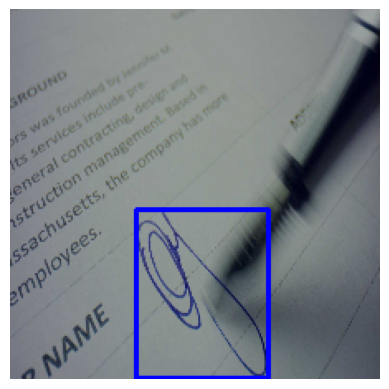

In [979]:
image_bounding_box = draw_bounding_box(load_image, load_label)

plt.imshow(cv2.cvtColor(image_bounding_box, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

define train and validation dataset variables

In [980]:
images_train_dir = "./dataset/train/images"
labels_train_dir = "./dataset/train/labels"

images_valid_dir = "./dataset/valid/images"
labels_valid_dir = "./dataset/valid/labels"

set image and label pairs

In [981]:
def get_image_labels_pairs(image_dir, label_dir):
  image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
  label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))

  image_label_pairs = []
  for img_path in image_paths:
    base_name = os.path.basename(img_path).split('.')[0]

    label_path = os.path.join(label_dir, base_name + ".txt")

    image_label_pairs.append((
      read_load_images(img_path),
      load_process_label(label_path)
    ))

  return image_label_pairs

In [982]:
train_data = get_image_labels_pairs(
    images_train_dir,
    labels_train_dir
)

In [983]:
len(train_data)

143

In [984]:
val_data = get_image_labels_pairs(
    images_valid_dir,
    labels_valid_dir
)

In [985]:
len(val_data)

35

split the train images data

train data

In [986]:
train_images, train_labels = zip(*train_data)

In [987]:
train_images = np.array(train_images).astype(np.float32) / 255.0
train_labels = np.array(train_labels).astype(np.float32)

In [988]:
len(train_images), len(train_labels)

(143, 143)

validation data

In [989]:
val_images, val_labels = zip(*val_data)

In [990]:
val_images = np.array(val_images).astype(np.float32) / 255.0
val_labels = np.array(val_labels).astype(np.float32)

In [991]:
len(val_images), len(val_labels)

(35, 35)

visualize random data

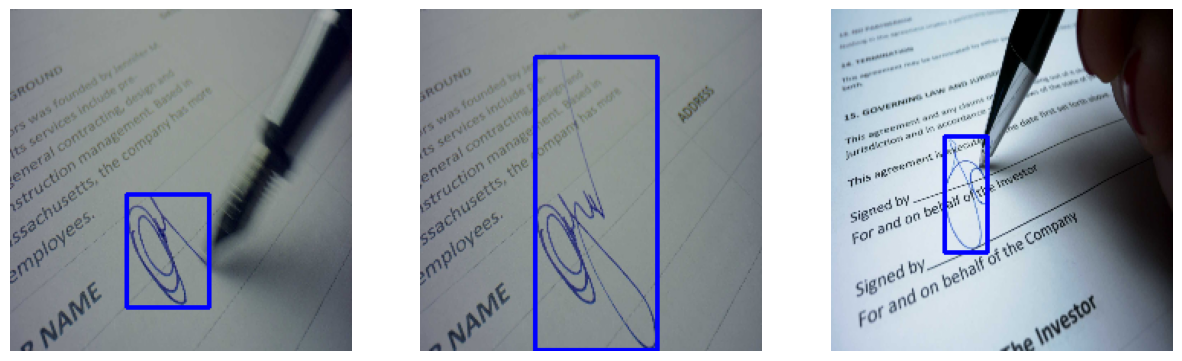

In [992]:
def plot_random_image(images, labels, show = 5, range_len = 10):
  random_indices = random.sample(range(0, range_len), show)
  fig, axes = plt.subplots(1, show, figsize=(15, 5))

  for i, idx in enumerate(random_indices):
      random_draw_ground = draw_bounding_box(images[idx], labels[idx])

      axes[i].imshow(cv2.cvtColor(random_draw_ground, cv2.COLOR_BGR2RGB))
      axes[i].axis("off")

  plt.show()

plot_random_image(train_images, train_labels, show = 3, range_len=142)

base model

In [993]:
model_1 = Sequential([
    keras_layer.Input(shape=(224, 224, 3)),
    keras_layer.Conv2D(32, 3, activation="relu", padding="same"),
    keras_layer.MaxPool2D(),
    keras_layer.Conv2D(64, 3, activation="relu", padding="same"),
    keras_layer.MaxPool2D(),
    keras_layer.Conv2D(128, 3, activation="relu", padding="same"),
    keras_layer.MaxPool2D(),
    keras_layer.GlobalAveragePooling2D(),
    keras_layer.Dense(64, activation="relu"),
    keras_layer.Dropout(0.5),
    keras_layer.Dense(4, activation="linear")
])


In [994]:
model_1.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_92 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_29     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,764 (397.52 KB)

 Trainable params: 101,764 (397.52 KB)

 Non-trainable params: 0 (0.00 B)

In [995]:
model_1.compile(
    loss = losses.huber,
    optimizer = optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy", "mae"]
)

In [996]:
history_model_1 = model_1.fit(
    train_images,
    train_labels,
    epochs=40,
    batch_size=4
)

Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.3868 - loss: 0.1296 - mae: 0.4236
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.4085 - loss: 0.0913 - mae: 0.3080
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3633 - loss: 0.0403 - mae: 0.2226
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4180 - loss: 0.0501 - mae: 0.2193
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4815 - loss: 0.0439 - mae: 0.2122
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.4389 - loss: 0.0561 - mae: 0.2242
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5959 - loss: 0.0283 - mae: 0.1871
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4323 - loss: 0.0352 - mae: 0.1983
Epoch 9/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3230 - loss: 0.0343 - mae: 0.1972
Epoch 10/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5777 - loss: 0.0265 - mae: 0.1776
Epoch 11/

evaluate the model

In [997]:
model_1.evaluate(val_images, val_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8527 - loss: 0.0035 - mae: 0.0487 


[0.00365696894004941, 0.8571428656578064, 0.050266217440366745]

In [998]:
model_1_preds_probs = model_1.predict(val_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


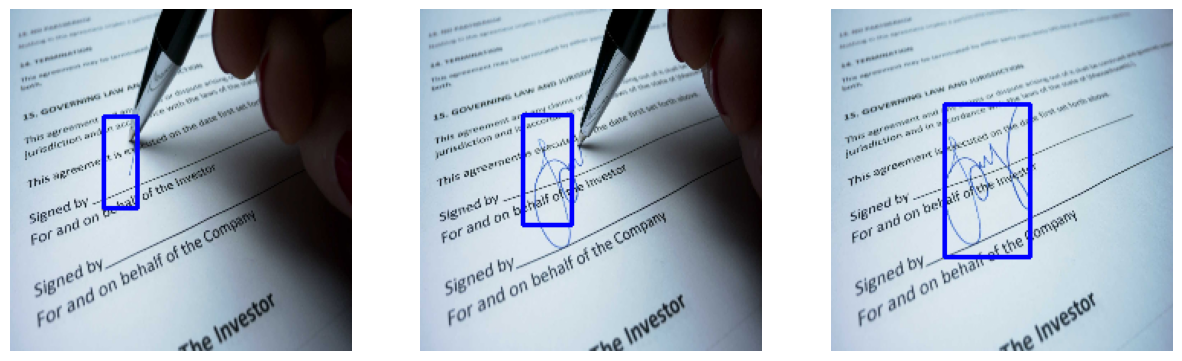

In [1005]:
plot_random_image(val_images, model_1_preds_probs, show=3, range_len=30)

In [1000]:
model_1.save("cnn_signature_model_v1.keras")